In [1]:
# Load ResNet pretrained on ImageNet

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import cv2
from tqdm import tqdm

from load_data import BiopsyDataset, get_balanced_dataloader, Nullmutation
from eval import get_accuracy_per_class

DATA_DIR = "../../data/biopsies_s1.0_anon_data/"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

# Load csv
csv_file = os.path.join(DATA_DIR, "biopsy_labels_anon_s1.0.csv")
df = pd.read_csv(csv_file)

C:\Users\321lu\AppData\Local\Temp\ipykernel_4748\4129861340.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Device: cuda


In [2]:
nm_dataset = Nullmutation(DATA_DIR)
len(nm_dataset)

Loaded patches from file
Class distribution:  {'wildtype': 2574, 'any nullmutation': 3291}


5865

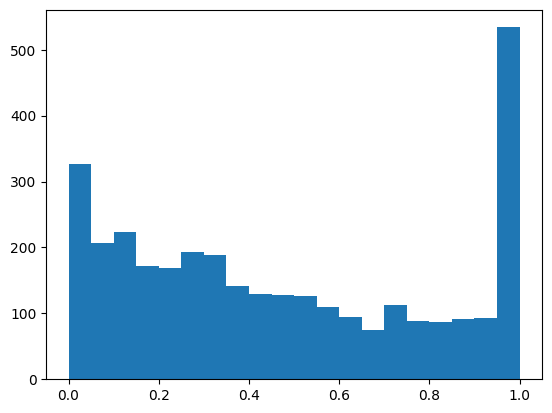

In [10]:
means = nm_dataset.patch_labels[nm_dataset.nm_indices].mean(dim=(-1,-2))[:,0]
# Plot histogram of means
plt.hist(means, bins=20)
pass

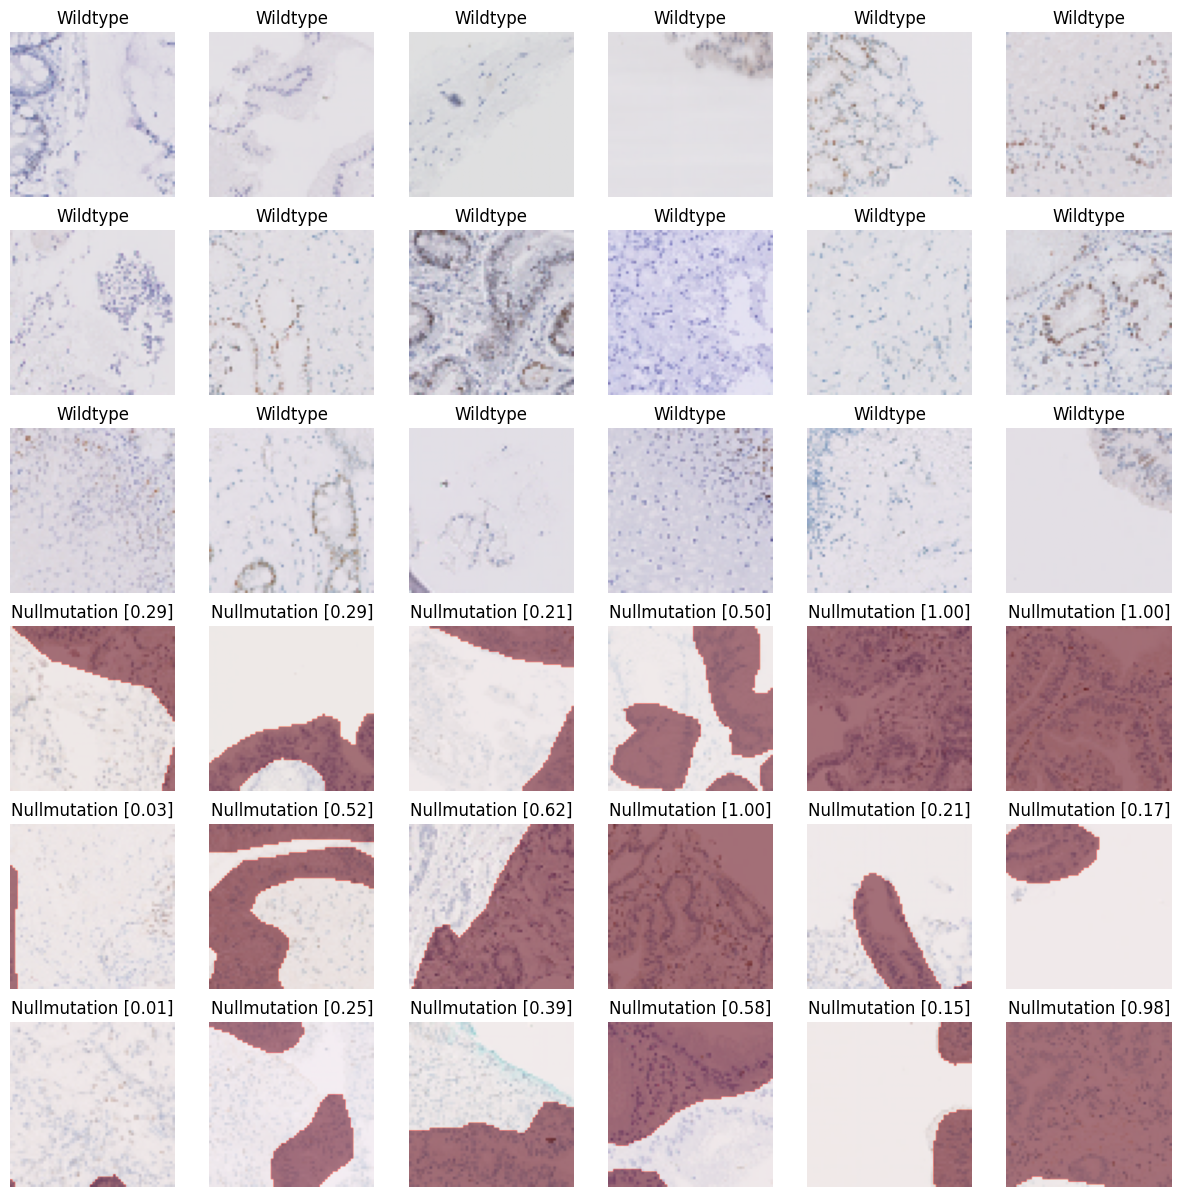

In [11]:
nm_dataset.plot_example_grid(n=6, random=True)

In [ ]:
# # Read the images
# root_dir = DATA_DIR
# imgs_dir = os.path.join(root_dir, "biopsies")
# widths = []
# heights = []
# skip = 0
# for img_file in tqdm(os.listdir(imgs_dir)):
#     img_file = os.path.join(imgs_dir, img_file)
#     img = plt.imread(img_file)
#     widths.append(img.shape[1])
#     heights.append(img.shape[0])

In [ ]:
# ws = np.array(widths)
# hs = np.array(heights)

# # Make sure width is always greater than height
# # If not, swap them
# for i in range(len(ws)):
#     if ws[i] < hs[i]:
#         ws[i], hs[i] = hs[i], ws[i]

# # Plot distribution of image sizes
# plt.hist(ws, bins=25, alpha=0.5, label='Width')
# plt.hist(hs, bins=25, alpha=0.5, label='Height')
# plt.legend(loc='upper right')
# # Save the plot
# plt.savefig(os.path.join(DATA_DIR, "image_sizes_1d.png"))
# plt.show()

# # Make 2D histogram of image sizes with 50 bins, width on x-axis, height on y-axis
# plt.hist2d(ws, hs, bins=20, cmap='Blues', range=[[0, 6000], [0, 6000]])
# plt.colorbar()
# plt.xlabel('Width')
# plt.ylabel('Height')
# # Save the plot
# plt.savefig(os.path.join(DATA_DIR, "image_sizes_2d.png"))
# plt.show()

In [ ]:
# Get count of each class
count = df['label'].value_counts()
print(count)

In [ ]:
# Read the images
root_dir = DATA_DIR
imgs_dir = os.path.join(root_dir, "biopsies")
imgs = []
skip = 0
for img_file in os.listdir(imgs_dir):
    # Load label
    img_id = int(img_file.split(".")[0])
    label = df[df['id'] == img_id]['label'].values[0]
    if label != 2: # Only show class 2
        continue
    if skip > 0:
        skip -= 1
        continue
    print("Image ID: {}, Label: {}".format(img_id, label))

    img_file = os.path.join(imgs_dir, img_file)
    img = plt.imread(img_file)
    img = torch.tensor(img).permute(2, 0, 1).float()

    fig, ax = plt.subplots(2, 2, figsize=(20, 20))
    # Show 4 different resizings of the image
    for i, size in enumerate([4, 16, 64, 256]):
        img_resized = torch.nn.functional.interpolate(img.unsqueeze(0), size=size, mode='bilinear', align_corners=False)
        ax[i//2, i%2].imshow(img_resized[0].permute(1, 2, 0).numpy())
        ax[i//2, i%2].axis('off')

        # Save just the resized image to root_dir as {img_id}_{size}.png
        img_resized = img_resized[0].permute(1, 2, 0).numpy()
        img_resized = (img_resized * 255).astype(np.uint8)
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(root_dir, "{}_{}.png".format(img_id, size)), img_resized)
    
    plt.show()

    plt.figure(figsize=(20,20))
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

    # If mask with img_id exists in masks/ folder, load it
    mask_file = os.path.join(root_dir, "masks", "{}.png".format(img_id))
    print(os.listdir(os.path.join(root_dir, "masks")))
    if os.path.exists(mask_file):
        mask = plt.imread(mask_file)
        mask = torch.tensor(mask).float()
        plt.figure(figsize=(20,20))
        plt.imshow(img.permute(1, 2, 0).numpy())
        mask_3ch = torch.stack([mask, mask, mask], dim=0)
        plt.imshow(mask_3ch.permute(1, 2, 0).numpy(), alpha=0.2)
        plt.axis('off')
        plt.show()

    size = 64
    EMPTY_MEAN_THRESHOLD = 0.8925
    patches = torch.nn.functional.unfold(img.unsqueeze(0), kernel_size=(size, size), stride=(size, size)) # (1, 3*size*size, n_patches)
    patches = patches.permute(0, 2, 1).reshape(-1, 3, size, size) # (n_patches, 3, size, size)
    nrows = int(img.shape[1] / size)
    ncols = int(img.shape[2] / size)
    # All patches with mean above EMPTY_MEAN_THRESHOLD are empty
    non_empty_idx = patches.mean(axis=-1).mean(axis=-1).mean(axis=-1) < EMPTY_MEAN_THRESHOLD
    non_empty_patches = patches[non_empty_idx]
    print(patches.shape, nrows, ncols)
    plt.imshow(non_empty_patches[0].permute(1, 2, 0).numpy())
    plt.show()

    if os.path.exists(mask_file):
        # Make patches of the mask, using mask_3ch
        mask_patches = torch.nn.functional.unfold(mask_3ch.unsqueeze(0), kernel_size=(size, size), stride=(size, size))
        mask_patches = mask_patches.permute(0, 2, 1).reshape(-1, 3, size, size)
        non_empty_mask_patches = mask_patches[non_empty_idx]
    break

In [ ]:
# Sanity check the patch empty checking and the nullmutation annotations
# Read the images
for img_file in tqdm(os.listdir(imgs_dir)):
    # img_file = "277.png"
    img_id = int(img_file.split(".")[0])

    # Load label
    label = df[df['id'] == img_id]['label'].values[0]
    
    mask_file = os.path.join(root_dir, "masks", "{}.png".format(img_id))
    if not os.path.exists(mask_file):
        # continue
        pass

    resize_factor = 0.25
    size = 64

    img_file = os.path.join(imgs_dir, img_file)
    img = plt.imread(img_file)
    img = torch.tensor(img).permute(2, 0, 1).float()
    new_size = (round(img.shape[1]*resize_factor/size)*size, 
                round(img.shape[2]*resize_factor/size)*size)
    # Resize the img so that the height and width are multiples of 256, rounded to the nearest multiple
    img = torch.nn.functional.interpolate(img.unsqueeze(0), size=new_size, 
        mode='bilinear', align_corners=False)[0]

    EMPTY_MEAN_THRESHOLD = 0.8925
    print(img.unsqueeze(0).shape)
    patches = torch.nn.functional.unfold(img.unsqueeze(0), kernel_size=(size, size), stride=(size, size)) # (1, 3*size*size, n_patches)
    patches = patches.permute(0, 2, 1).reshape(-1, 3, size, size) # (n_patches, 3, size, size)
    print("n patches", len(patches))
    # All patches with mean above EMPTY_MEAN_THRESHOLD are empty
    # non_empty = patches.mean(axis=-1).mean(axis=-1).mean(axis=-1) < EMPTY_MEAN_THRESHOLD
    # All patches with qrange below 0.1 are empty
    qranges = torch.quantile(patches.view(patches.shape[0], -1), 0.75, dim=-1) - torch.quantile(patches.view(patches.shape[0], -1), 0.01, dim=-1)
    non_empty = qranges >= 0.1
    non_empty_idx = torch.where(non_empty)[0]
    non_empty_patches = patches[non_empty_idx]

    # Make grid from the patches with 2 pixel black border in between
    nrows = int(img.shape[1] / size)
    ncols = int(img.shape[2] / size)
    grid = torchvision.utils.make_grid(patches, nrow=ncols, padding=2, pad_value=0)
    # Make img for visualization called colors, with transparency channel
    colors = torch.zeros((4, grid.shape[1], grid.shape[2]))

    plt.figure(figsize=(20,20))
    plt.imshow(np.zeros_like(grid.permute(1, 2, 0).numpy())) # Just to initialize the plot

    # Put red squares on the empty patches
    for i in range(nrows):
        for j in range(ncols):
            idx = i*ncols + j
            if idx in non_empty_idx:
                continue
            # Draw red square in the middle of the patch
            gridsize = size+2
            x1 = 2+j*gridsize + size//4
            y1 = 2+i*gridsize + size//4
            x2 = 2+j*gridsize + 3*size//4
            y2 = 2+i*gridsize + 3*size//4
            grid[0, y1:y2, x1:x2] = 1
            grid[1, y1:y2, x1:x2] = 0
            grid[2, y1:y2, x1:x2] = 0

    if os.path.exists(mask_file):
        mask = plt.imread(mask_file)
    else:
        mask = np.zeros((img.shape[1], img.shape[2]))
    mask = torch.tensor(mask).float() # (h, w)
    mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), size=new_size,
        mode='nearest')[0][0] # (h, w)
    print(mask.unsqueeze(0).shape)
    mask_patches = torch.nn.functional.unfold(mask.unsqueeze(0), kernel_size=(size, size), stride=(size, size)) # (size*size, n_patches)
    mask_patches = mask_patches.permute(1, 0).reshape(-1, 1, size, size)
    print("mask patches", len(mask_patches))

    fig, ax1 = plt.subplots(1,1)
    ax1.imshow(mask_patches[7][0])
    plt.show()

    grid_mask = torchvision.utils.make_grid(mask_patches, nrow=ncols, padding=2, pad_value=0)[0]

    # Put blue squares on the nullmutation
    for i in range(nrows):
        for j in range(ncols):
            idx = i*ncols + j
            if False:
                # Put text of the mean of the mask patch in the middle of the patch
                plt.text(j*gridsize + size//2, i*gridsize + size//2 - 20, "{:.2f}".format(mask_patches[idx].mean().item()), ha='center', va='center', color='black')
                # Put text of the mean of the image patch in the middle of the patch, below the mask patch text
                plt.text(j*gridsize + size//2, i*gridsize + size//2, "{:.2f}".format(patches[idx].mean().item()), ha='center', va='center', color='black')
                # Put text of the std of the image patch in the middle of the patch, below the mean text
                # plt.text(j*gridsize + size//2, i*gridsize + size//2 + 20, "{:.2f}".format(patches[idx].std().item()), ha='center', va='center', color='black')
                # Put text of the range of values of the image patch in the middle of the patch, below the mean text
                # We'll use upper quantile - lower quantile as the range
                # qrange = torch.quantile(patches[idx], 0.75) - torch.quantile(patches[idx], 0.01)
                qrange = qranges[idx]
                plt.text(j*gridsize + size//2, i*gridsize + size//2 + 20, "{:.2f}".format(qrange.item()), ha='center', va='center', color='black')

            if mask_patches[idx].mean() < 0.04:
                continue
            # Draw green square in the middle of the patch
            gridsize = size+2
            x1 = 2+j*gridsize + size//4
            y1 = 2+i*gridsize + size//4
            x2 = 2+j*gridsize + 3*size//4
            y2 = 2+i*gridsize + 3*size//4
            colors[1, y1:y2, x1:x2] = mask_patches[idx].mean()
            colors[3, y1:y2, x1:x2] = 0.5

    # print(patches.shape)

    # Make grid mask transparent where it's 0
    grid_mask_rgba = torch.stack([grid_mask, grid_mask, grid_mask, grid_mask], dim=0)

    plt.imshow(grid_mask_rgba.permute(1, 2, 0).numpy())
    blended_add = grid + colors[0:3]*colors[3]
    plt.imshow(blended_add.permute(1, 2, 0).numpy(), alpha=0.90)
    plt.axis('off')
    # plt.savefig(os.path.join(root_dir, "sanity_check", f"patch_grid{img_id}.png"), bbox_inches='tight')
    plt.show()
    # plt.close()

    break

In [ ]:
def plot_patches(patches, nrows, ncols, mask_patches=None, show_mean=True):
    fig, ax = plt.subplots(nrows,ncols, figsize=(ncols*2,nrows*2))
    for i in range(nrows):
        for j in range(ncols):
            ax[i,j].axis("off")
            if i*ncols+j >= len(patches):
                continue
            patch = patches[i*ncols+j].permute(1, 2, 0).numpy()
            if show_mean:
                # color = "red" if patch.mean() < 10 else "black"
                # ax[i,j].text(105,128, f"{patch.std():.2f}", c=color)
                color = "red" if patch.mean() > EMPTY_MEAN_THRESHOLD else "black"
                patch_size = patch.shape[0]
                x,y = patch_size//2, patch_size//2
                ax[i,j].text(x,y, f"{patch.mean():.2f}", c=color, ha='center', va='center')
            ax[i,j].imshow(patch)

            if mask_patches is not None:
                mask_patch = mask_patches[i*ncols+j].permute(1, 2, 0).numpy()
                # ax[i,j].imshow(mask_patch, alpha=0.2)
                # If mask_patch is not empty, make overlay
                if mask_patch.mean() > 0.1:
                    mask_patch = np.zeros_like(patch)
                    mask_patch[:,:,2] = 1
                    ax[i,j].imshow(mask_patch, alpha=0.1)

    plt.show()


plot_patches(patches, nrows, ncols)
ncols2 = 10
plot_patches(non_empty_patches, int(np.ceil(len(non_empty_patches)/ncols2)), ncols2,
    show_mean=False)
plot_patches(non_empty_patches, int(np.ceil(len(non_empty_patches)/ncols2)), ncols2, 
    non_empty_mask_patches, show_mean=False)

In [ ]:
fig, ax = plt.subplots(nrows,ncols, figsize=(ncols*2,nrows*2))
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].axis("off")
        if i*ncols+j >= len(patches):
            continue
        patch = patches[i*ncols+j].permute(1, 2, 0).numpy()
        ax[i,j].imshow(patch)

        if patch.mean() > EMPTY_MEAN_THRESHOLD:
            mask_patch = np.zeros_like(patch)
            mask_patch[:,:,:] = 0
            ax[i,j].imshow(mask_patch, alpha=0.5)

        if mask_patches is not None:
            mask_patch = mask_patches[i*ncols+j].permute(1, 2, 0).numpy()
            # ax[i,j].imshow(mask_patch, alpha=0.2)
            # If mask_patch is not empty, make overlay
            if mask_patch.mean() > 0.1:
                mask_patch = np.zeros_like(patch)
                mask_patch[:,:,2] = 1
                ax[i,j].imshow(mask_patch, alpha=np.random.uniform(0.1, 0.3))

plt.show()

In [ ]:
# Write a Dataset class for the biopsies
class PatchDataset(torch.utils.data.Dataset):
    """
    Biopsy patch dataset. getitem returns (patch, label) tuples.
    grid_spacing: the distance between the centers of the patches. default 256
    size: the size of the patches. default 64

    If grid_spacing and size are the same, wsi spacing is 1.0 (because the source data is spacing 1.0)
    If grid_spacing is 256 and size is 64, wsi spacing is 4.0
    """
    def __init__(self, root_dir, labels_filename="train", transform=None, class_names=None, size=64, grid_spacing=256):
        """
        Args:
            root_dir (string): Directory with all the biopsies.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Read the labels
        labels_file = os.path.join(root_dir, f"{labels_filename}.csv")
        self.labels = np.loadtxt(labels_file, delimiter=",", skiprows=1)
        self.labels = self.labels.astype(int)

        self.num_classes = len(np.unique(self.labels[:, 1]))
        if class_names and self.num_classes != len(class_names):
            self.num_classes = len(class_names)
        self.class_names = class_names
        
        # Read the images and turn into patches
        imgs_dir = os.path.join(root_dir, "imgs")
        self.patches = []
        self.patch_labels = []
        for idx, label in tqdm(self.labels):
            img_file = os.path.join(imgs_dir, f"{idx}.png")
            img = plt.imread(img_file)
            img = torch.tensor(img).permute(2, 0, 1).float()
            
            patches = torch.nn.functional.unfold(img.unsqueeze(0), 
                kernel_size=(grid_spacing, grid_spacing), 
                stride=(grid_spacing, grid_spacing)) # (1, 3*grid_spacing*grid_spacing, n_patches)
            patches = patches.permute(0, 2, 1).reshape(-1, 3, grid_spacing, grid_spacing) # (n_patches, 3, grid_spacing, grid_spacing)
            self.patches.extend(patches)
            self.patch_labels.extend([label] * len(patches))
        self.patches = torch.stack(self.patches)

        # All patches with mean above 0.875 are empty
        non_empty_idx = self.patches.mean(axis=-1).mean(axis=-1).mean(axis=-1) < 0.875
        self.patches = self.patches[non_empty_idx]
        self.patches = torch.nn.functional.interpolate(self.patches, size=(size, size))
        self.patch_labels = np.array(self.patch_labels)[non_empty_idx]
        
    def __len__(self):
        return len(self.patch_labels)
    
    def __getitem__(self, idx):
        label = int(self.patch_labels[idx])
        image = self.patches[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

    def plot_example_grid(self, n=5, random=True, figsize=(15, 15)):
        """Plot a grid with n*n examples."""
        if random:
            indices = np.random.choice(len(self), size=n*n, replace=False)
        else:
            indices = np.arange(n*n)
        
        fig, axs = plt.subplots(n, n, figsize=figsize)
        for i, ax in enumerate(axs.flatten()):
            ax.imshow(self[indices[i]][0].permute(1, 2, 0))
            ax.set_title(self.class_names[self[indices[i]][1]])
            ax.axis("off")
        plt.show()

In [ ]:
biopsies_dataset = PatchDataset(root_dir=DATA_DIR, class_names=["Wildtype", "Overexpression", "Nullmutation", "Doubleclone"], 
    size=32, labels_filename="test")

In [ ]:
biopsies_dataset.plot_example_grid(figsize=(30,30))

In [ ]:
class BagDataset(torch.utils.data.Dataset):
    """
    Biopsy patch bag dataset. getitem returns (bag, label) tuples.
    grid_spacing: the distance between the centers of the patches. default 256
    size: the size of the patches. default 64

    If grid_spacing and size are the same, wsi spacing is 1.0 (because the source data is spacing 1.0)
    If grid_spacing is 256 and size is 64, wsi spacing is 4.0
    """
    def __init__(self, root_dir, labels_filename="train", transform=None, class_names=None, size=64, grid_spacing=256, data_limit=None):
        """
        Args:
            root_dir (string): Directory with all the biopsies.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Read the labels
        labels_file = os.path.join(root_dir, f"{labels_filename}.csv")
        self.labels = np.loadtxt(labels_file, delimiter=",", skiprows=1)
        self.labels = self.labels.astype(int)
        if data_limit:
            self.labels = self.labels[:data_limit]

        self.num_classes = len(np.unique(self.labels[:, 1]))
        if class_names and self.num_classes != len(class_names):
            self.num_classes = len(class_names)
        self.class_names = class_names
        
        # Read the images and turn into patches
        imgs_dir = os.path.join(root_dir, "biopsies")
        self.bags = []
        self.bag_sizes = []
        for idx, label in tqdm(self.labels):
            img_file = os.path.join(imgs_dir, f"{idx}.png")
            img = plt.imread(img_file)
            img = torch.tensor(img).permute(2, 0, 1).float()
            
            patches = torch.nn.functional.unfold(img.unsqueeze(0), 
                kernel_size=(grid_spacing, grid_spacing), 
                stride=(grid_spacing, grid_spacing)) # (1, 3*grid_spacing*grid_spacing, n_patches)
            patches = patches.permute(0, 2, 1).reshape(-1, 3, grid_spacing, grid_spacing) # (n_patches, 3, grid_spacing, grid_spacing)
            non_empty_idx = patches.mean(axis=-1).mean(axis=-1).mean(axis=-1) < 0.875
            patches = patches[non_empty_idx]
            patches = torch.nn.functional.interpolate(patches, size=(size, size))

            if len(patches) == 0:
                print(f"Empty bag: {idx}")
                continue
            self.bags.append(patches)
            self.bag_sizes.append(len(patches))
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = int(self.labels[idx, 1])
        bag = self.bags[idx]
        
        if self.transform:
            # Apply the same transform to all patches in the bag
            bag = torch.stack([self.transform(patch) for patch in bag])
        
        return (bag, label)

    def plot_example_grid(self, n=5, random=True, figsize=(15, 15)):
        """Plot a grid with n*n examples from different bags."""
        if random:
            indices = np.random.choice(len(self), size=n*n, replace=False)
        else:
            indices = np.arange(n*n)
        
        fig, axs = plt.subplots(n, n, figsize=figsize)
        for i, ax in enumerate(axs.flatten()):
            bag, label = self[indices[i]]
            idx = int(len(bag)/2)
            if random:
                idx = np.random.choice(len(bag))
            patch = bag[idx]
            ax.imshow(patch.permute(1, 2, 0))
            ax.set_title(self.class_names[label])
            ax.axis("off")
        plt.show()


In [ ]:
biopsies_dataset = BagDataset(root_dir=DATA_DIR, class_names=["Wildtype", "Overexpression", "Nullmutation", "Doubleclone"], 
    size=64, labels_filename="test", transform=None, data_limit=16)

In [ ]:
class RandomRotation90:
    def __init__(self):
        self.degrees = [0., 90., 180., 270.]

    def __call__(self, img):
        degree = np.random.choice(self.degrees)
        return torchvision.transforms.functional.rotate(img, degree)

transform = torchvision.transforms.Compose([
    # Convert from tensor to PIL image
    torchvision.transforms.ToPILImage(),
    # torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomVerticalFlip(),
    # RandomRotation90(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
    # lambda x: print(x.max(), x.min()) or x
])

In [ ]:
biopsies_dataset.transform = None
biopsies_dataset.plot_example_grid(figsize=(30,30), n=4, random=False)
biopsies_dataset.transform = transform
biopsies_dataset.plot_example_grid(figsize=(30,30), n=4, random=False)